<a href="https://colab.research.google.com/github/livalgo/interactive-pipe-examples/blob/main/interactive_pipe_captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⏯ [`interactive_pipe` website](https://balthazarneveu.github.io/interactive_pipe/)

![](https://balthazarneveu.github.io/interactive_pipe/static/interact-pipe-logo-horizontal-rgb.svg)


## Let's make a captcha


# Full tutorial on shared context and UI design


**Note** : The same tutorial is also available on [🤗 HF spaces](https://huggingface.co/spaces/balthou/interactive-pipe-captcha)

In [ ]:
# Mandatory installation.
!pip install "ipywidgets>=7,<8"
!pip install interactive-pipe>=0.8.3

In [1]:
from interactive_pipe import interactive_pipeline, interactive, Image
from typing import Tuple
import numpy as np
from interactive_pipe.helper import _private

# Cache mechanism
- Required to avoid performing "model training" (even if small).
- Save epochs results into `context`, plot inference without re-performing training.

In [2]:
# Helper functions
# ----------------


def flip_image(img, flip=True, mirror=True):
    img = img[::-1] if flip else img
    img = img[:, ::-1] if mirror else img
    return img


def get_crop(img, pos_x, pos_y, crop_size=0.1):
    c_size = int(crop_size * img.shape[0])
    crop_x = (int(pos_x * img.shape[1]), int((pos_x) * img.shape[1]) + c_size)
    crop_y = (int(pos_y * img.shape[0]), int((pos_y) * img.shape[0]) + c_size)
    return crop_x, crop_y

# Processing blocks
# -----------------


def generate_feedback_ribbon() -> Tuple[np.ndarray, np.ndarray]:
    """Generate green and red ribbons for feedback"""
    flat_array = np.ones((800, 12, 3))
    colors = [[0., 1., 0.], [1., 0., 0.]]
    ribbons = [flat_array*np.array(col)[None, None, :] for col in colors]
    return ribbons[0], ribbons[1]


DIFFICULY = {"easy": 0.18, "medium": 0.1, "hard": 0.05}
DIFFICULY_LEVELS = list(DIFFICULY.keys())


def generate_random_puzzle(
    seed: int = 43,
    difficulty: str = DIFFICULY_LEVELS[0],
    context: dict = {}
):
    """Generate random puzzle configuration and store in context.

    Configuration = 2D position and flip/mirror.
    Freeze seed for reproducibility.
    """
    np.random.seed(seed)
    pos_x, pos_y = np.random.uniform(0.2, 0.8, 2)
    context["puzzle_pos"] = (pos_x, pos_y)
    context["puzzle_flip_mirror"] = np.random.choice([True, False], 2)
    context["puzzle_piece_size"] = DIFFICULY.get(difficulty, 0.18)


def create_puzzle(
    img: np.ndarray,
    intensity: float = 0.4,
    context: dict = {}
) -> Tuple[np.ndarray, np.ndarray]:
    """Extract puzzle piece from image. Make a dark hole where the """
    out = img.copy()
    x_gt, y_gt = context["puzzle_pos"]
    flip_gt, mirror_gt = context["puzzle_flip_mirror"]
    cs_x, cs_y = get_crop(
        img, x_gt, y_gt, crop_size=context["puzzle_piece_size"])
    crop = img[cs_y[0]:cs_y[1], cs_x[0]:cs_x[1], ...]
    out[cs_y[0]:cs_y[1], cs_x[0]:cs_x[1]] = intensity*crop
    crop = flip_image(crop, flip=flip_gt, mirror=mirror_gt)
    return out, crop


def flip_mirror_piece(
    piece: np.ndarray,
    flip: bool = False,
    mirror: bool = False,
    context: dict = {}
) -> np.ndarray:
    """Flip and/or mirror the puzzle piece."""
    context["user_flip_mirror"] = (flip, mirror)
    return flip_image(piece.copy(), flip=flip, mirror=mirror)


def place_puzzle(
    puzzle: np.ndarray,
    piece: np.ndarray,
    pos_x: float = 0.5,
    pos_y: float = 0.5,
    context: dict = {}
) -> np.ndarray:
    """Place the puzzle piece at the user-defined position."""
    out = puzzle.copy()
    context["user_pos"] = (pos_x, pos_y)
    cp_x, cp_y = get_crop(
        img, pos_x, pos_y, crop_size=context["puzzle_piece_size"])
    out[cp_y[0]:cp_y[1], cp_x[0]:cp_x[1]] = piece
    return out


TOLERANCES = {"low": 0.01, "medium": 0.02, "high": 0.05}
TOLERANCE_LEVELS = list(TOLERANCES.keys())


def check_puzzle(tolerance: str = "low", context: dict = {}) -> None:
    """Check if the user placed the puzzle piece correctly.
    Store the result in the context."""
    x_gt, y_gt = context["puzzle_pos"]
    flip_gt, mirror_gt = context["puzzle_flip_mirror"]
    x, y = context["user_pos"]
    flip, mirror = context["user_flip_mirror"]
    check_pos = np.allclose([x_gt, y_gt], [x, y],
                            atol=TOLERANCES.get(tolerance, 0.01))
    check_flip_mirror = (flip_gt == flip) and (mirror_gt == mirror)
    success = check_pos and check_flip_mirror
    context["success"] = success


def display_feedback(
    puzzle: np.ndarray,
    ok_ribbon: np.ndarray,
    nok_ribbon: np.ndarray,
    context: dict = {}
) -> np.ndarray:
    """Display green/red ribbon on the right side of the puzzle."""
    success = context.get("success", False)
    ribbon = ok_ribbon if success else nok_ribbon
    out = np.hstack([puzzle, ribbon[:puzzle.shape[0], ...]])
    return out

# pipeline definition
# -------------------


def captcha_pipe(inp):
    ok_ribbon, nok_ribbon = generate_feedback_ribbon()
    generate_random_puzzle()
    puzzle, puzzle_piece = create_puzzle(inp)
    puzzle_piece = flip_mirror_piece(puzzle_piece)
    puzzle = place_puzzle(puzzle, puzzle_piece)
    check_puzzle()
    puzzle = display_feedback(puzzle, ok_ribbon, nok_ribbon)
    return puzzle

# add interactivity
# -----------------


def main(img: np.ndarray, backend="gradio", debug: bool = False):
    # If debug mode, add interactive sliders to tune the puzzle generation
    # and help the "game master" design a feasible puzzle.
    if debug:
        interactive(
            tolerance=(TOLERANCE_LEVELS[0], TOLERANCE_LEVELS, "Tolerance")
        )(check_puzzle)
        interactive(
            seed=(43, [0, 100], "Puzzle seed"),
            difficulty=(DIFFICULY_LEVELS[0], DIFFICULY_LEVELS, "Difficulty")
        )(generate_random_puzzle)
    interactive(
        pos_x=(0.5, [0.1, 0.9, 0.005], "Position X", ["left", "right"]),
        pos_y=(0.5, [0.1, 0.9, 0.005], "Position Y", ["up", "down"]),
    )(place_puzzle)
    # left, right, up, down will only supported when using the Qt backend
    # Note: step size does not have proper support with nb backend.
    interactive(
        flip=(False, "Flip Image"),
        mirror=(False, "Mirror Image"),
    )(flip_mirror_piece)
    captcha_pipe_interactive = interactive_pipeline(
        gui=backend,
        cache=True,
    )(captcha_pipe)
    captcha_pipe_interactive(img)


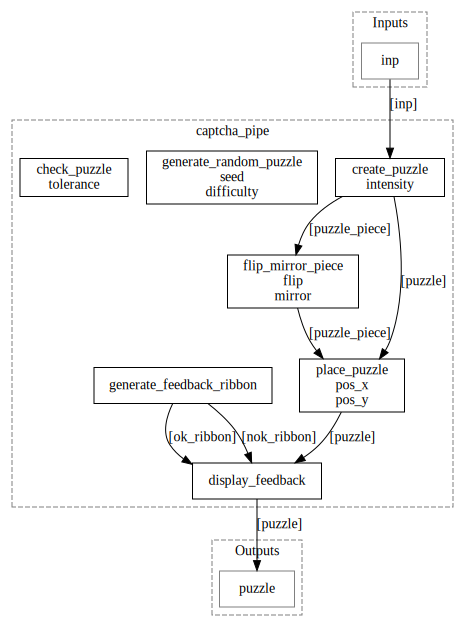

In [3]:
headless_pipe = interactive_pipeline(gui=None)(captcha_pipe)
headless_pipe.graph_representation(ortho=False)

interactive(children=(IntSlider(value=43, description='Puzzle seed', layout=Layout(width='500px'), style=Slide…

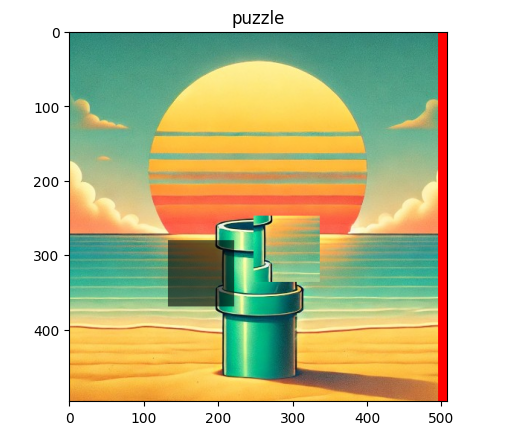

In [5]:
import urllib.request
imgURL = "https://huggingface.co/spaces/balthou/interactive-pipe-captcha/resolve/main/sample.jpg"
urllib.request.urlretrieve(imgURL, "sample.jpg")
img = Image.load_image("sample.jpg")
main(img, backend="nb", debug=True)